## Robust PCA Algorithm Implementation

In [1]:
import numpy as np
import scipy.linalg as sp
from tqdm import tqdm

def robust_PCA(D, num_its=5000):
    n, m = D.shape
    lam, mu = 1/np.sqrt(max(n, m)), 1.25/np.abs(D).mean()
    L, S, Y = np.zeros_like(D), np.zeros_like(D), np.zeros_like(D)

    for it in tqdm(range(num_its)):
        U, s, V = sp.svd(D - S + Y / mu, full_matrices=False)
        L = U @ np.diag(np.maximum(s - 1/mu, 0)) @ V
        S = np.sign(D - L + Y / mu) * np.maximum(np.abs(D - L + Y / mu) - lam / mu, 0)
        Y += mu * (D - L - S)
        if np.linalg.norm(D - L - S, 'fro') / np.linalg.norm(D, 'fro') < 1e-7:
            break

    return L, S


In [2]:
def calculate_metrics(D, L, S):
    """
    Calculate and print the error and fraction of outliers.
    """
    error = np.linalg.norm(D - L - S, ord="fro") / np.linalg.norm(D, ord="fro")
    print(f"Reconstruction error: {error:.6f}")

    outliers_fraction = np.mean(S != 0)
    print(f"Fraction of outliers: {outliers_fraction:.3f}")

    intrinsic_rank = np.linalg.matrix_rank(L)
    original_rank = np.linalg.matrix_rank(D)
    print(f"Intrinsic rank: {intrinsic_rank}, Original rank: {original_rank}")

## Replication of Candes et al. (2011) Numerical Experiment

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

def load_and_resize_images(folder, resize_factor, max_images=1000):
    images = []
    resized_frames = []
    count = 0
    for filename in os.listdir(folder):
        if not filename.endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, None, fx=resize_factor, fy=resize_factor)
            # Convert image to float64
            img_resized = img_resized.astype(np.float64)
            images.append(img_resized.flatten())
            resized_frames.append(img_resized)
            count += 1
            if count >= max_images:
                break
        except Exception as e:
            print(f"Error loading or resizing image: {filename}")
            continue
    return np.array(images).T, resized_frames

mall_images_folder = 'mall_dataset'
resize_factor = 0.4
max_images = 50
mall_images, resized_frames = load_and_resize_images(mall_images_folder, resize_factor, max_images)

In [4]:
L_mall, S_mall = robust_PCA(mall_images, num_its=5000)
calculate_metrics(mall_images, L_mall, S_mall)

 23%|██▎       | 1169/5000 [11:23<37:21,  1.71it/s]

Reconstruction error: 0.000000
Fraction of outliers: 0.837
Intrinsic rank: 24, Original rank: 50


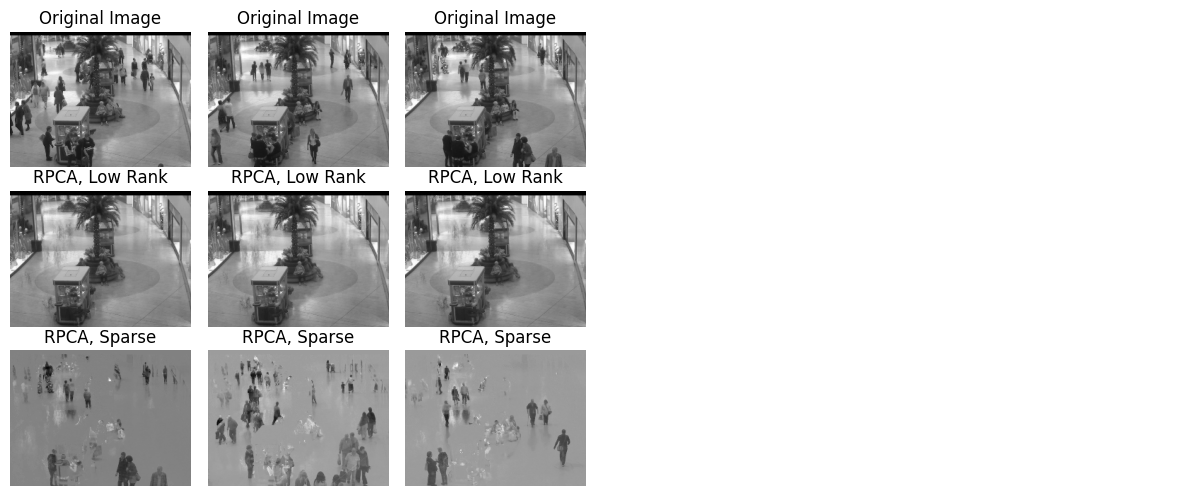

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 6, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(3):
    background = L_mall[:, i+2].reshape(resized_frames[i+2].shape)
    foreground = S_mall[:, i+2].reshape(resized_frames[i+2].shape)

    axs[0, i].imshow(resized_frames[i], cmap='gray')
    axs[0, i].set_title("Original Image")

    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("RPCA, Low Rank")

    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("RPCA, Sparse")

fig.tight_layout()

## Extending Experiment to Mislabel Detection Domain

### Computing fastdup Embeddings

In [3]:
import fastdup 
import pandas as pd

annot = pd.read_csv('data/crops/crops_info.csv')

input_dir='data/crops'
work_dir = 'data/fd_work_dir'

fd = fastdup.create(input_dir = input_dir, work_dir = work_dir)
fd.run(license='magical', annotations=annot, threshold=0, nearest_neighbors_k=10, overwrite=True, high_accuracy=True)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2024-05-16 08:50:50 [INFO] Going to loop over dir /var/folders/kf/g3hh_5m92h57f7bx34j710zw0000gn/T/tmpnom_icav.csv
2024-05-16 08:50:50 [INFO] Found total 1912 images to run on, 1912 train, 0 test, name list 1912, counter 1912 
2024-05-16 08:50:50 [WARNING] Image /Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_20.jpg is too small, image size is 27 x 7, min_input_image_width=10
2024-05-16 08:50:50 [WARNING] Image /Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_32.jpg is too small, image size is 34 x 9, min_input_image_width=10
2024-05-16 08:50:50 [WARNING] Image /Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_124.jpg is too small, image size is 38 x 8, min_input_image_width=10
2024-05-16 08:50:50 [WARNING] Image /Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_142.jpg is too small, image size is 35 x 8, min_input_ima

0

### Computing RPCA-Reduction of BLIP-2 Embeddings

In [ ]:
import fastdup

filenames, vecs = fastdup.load_binary_feature(filename='./data/fd_work_dir/atrain_features.dat', d=960)
vecs = vecs.reshape(-1, len(vecs))
vecs = vecs[:, :500]

L, S = robust_PCA(vecs, num_its=5000)

In [16]:
calculate_metrics(vecs, L, S)

Reconstruction error: 0.000000
Fraction of outliers: 0.698
Intrinsic rank: 291, Original rank: 500


### Loading Annotations and Seeding Mislabels

In [22]:
import fastdup 
import pandas as pd
import numpy as np

#annot = pd.read_csv('data/crops/crops_info.csv')
annot = fd.annotations()
annot.drop(columns=['error_code', 'index', 'filesize', 'is_valid', 'fd_index'], inplace=True)

np.random.seed(42)  # For reproducibility
mislabel_indices = np.random.choice(annot.index, size=200, replace=False)
new_labels = []
for index in mislabel_indices:
    original_label = annot.loc[index, 'label']
    possible_labels = annot['label'].unique()
    possible_labels = possible_labels[possible_labels != original_label]
    new_label = np.random.choice(possible_labels)
    new_labels.append(new_label)
annot['augmented_label'] = annot['label'].copy()
annot.loc[mislabel_indices, 'augmented_label'] = new_labels

annot

/var/folders/kf/g3hh_5m92h57f7bx34j710zw0000gn/T/ipykernel_55858/1232253309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot.drop(columns=['error_code', 'index', 'filesize', 'is_valid', 'fd_index'], inplace=True)
/var/folders/kf/g3hh_5m92h57f7bx34j710zw0000gn/T/ipykernel_55858/1232253309.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['augmented_label'] = annot['label'].copy()


,filename,label,augmented_label
0,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_0.jpg,bus,bus
1,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_1.jpg,bus,bus
2,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_2.jpg,bus,bus
3,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_3.jpg,cng,cng
4,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_4.jpg,person,person
...,...,...,...
1907,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_train_974.jpg,bicycle,bicycle
1908,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_train_976.jpg,car,car
1909,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_train_977.jpg,car,car
1910,/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_train_978.jpg,car,car


In [ ]:
annot.save

### Computing Mislabel Probabilities

In [11]:
S

(['/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_0.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_1.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_2.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_3.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_4.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_5.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_6.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_7.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_8.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_9.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test_10.jpg',
  '/Users/guysinger/Desktop/math_methods_final_project/data/crops/crop_test

In [12]:
from sklearn.neighbors import NearestNeighbors

def compute_mislabel_probabilities(S_matrix, labels):
    nn = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(S_matrix.T)
    distances, indices = nn.kneighbors()

    mislabel_probs = []
    for i in range(len(indices)):
        nn_labels = labels.iloc[indices[i]]  # Labels of nearest neighbors
        try:
            same_label_dist = distances[i][nn_labels == labels.iloc[i]]  # Distances to neighbors with same label
            diff_label_dist = distances[i][nn_labels != labels.iloc[i]]  # Distances to neighbors with different label
            if len(same_label_dist) == 0:
                mislabel_prob = 999  # Avoid division by zero
            else:
                mislabel_prob = np.mean(diff_label_dist) / np.mean(same_label_dist)
            mislabel_probs.append(mislabel_prob)
        except ZeroDivisionError:
            mislabel_probs.append(999)
    
    return np.array(mislabel_probs)

filenams, S = fastdup.load_binary_feature(filename='./data/fd_work_dir/atrain_features.dat', d=960)

# Step 2: Compute mislabel probabilities
mislabel_probs = compute_mislabel_probabilities(S, annot['augmented_label'])

annot['mislabel_prob'] = mislabel_probs
annot

Read a total of  1844 images


IndexError: positional indexers are out-of-bounds

In [23]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

filenames, S = fastdup.load_binary_feature(filename='./data/fd_work_dir/atrain_features.dat', d=960)

annot_filtered = annot[annot['filename'].isin(filenames)]

annot_filtered = annot_filtered.set_index('filename').loc[filenames].reset_index()

def compute_mislabel_probabilities(S_matrix, labels):
    nn = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(S_matrix.T)
    distances, indices = nn.kneighbors()

    mislabel_probs = []
    for i in range(len(indices)):
        nn_labels = labels.iloc[indices[i]]  # Labels of nearest neighbors
        try:
            same_label_dist = distances[i][nn_labels == labels.iloc[i]]  # Distances to neighbors with the same label
            diff_label_dist = distances[i][nn_labels != labels.iloc[i]]  # Distances to neighbors with different labels
            if len(same_label_dist) == 0:
                mislabel_prob = 999  # Avoid division by zero
            else:
                mislabel_prob = np.mean(diff_label_dist) / np.mean(same_label_dist)
            mislabel_probs.append(mislabel_prob)
        except ZeroDivisionError:
            misbrain_probs.append(999)
    
    return np.array(mislabel_probs)

# Compute mislabel probabilities
mislabel_probs = compute_mislabel_probabilities(S, annot_filtered['augmented_label'])

# Assign computed probabilities back to the DataFrame
annot_filtered['mislabel_prob'] = mislabel_probs

# Print or return the updated DataFrame
print(annot_filtered)


Read a total of  1844 images


ValueError: Length of values (960) does not match length of index (1844)

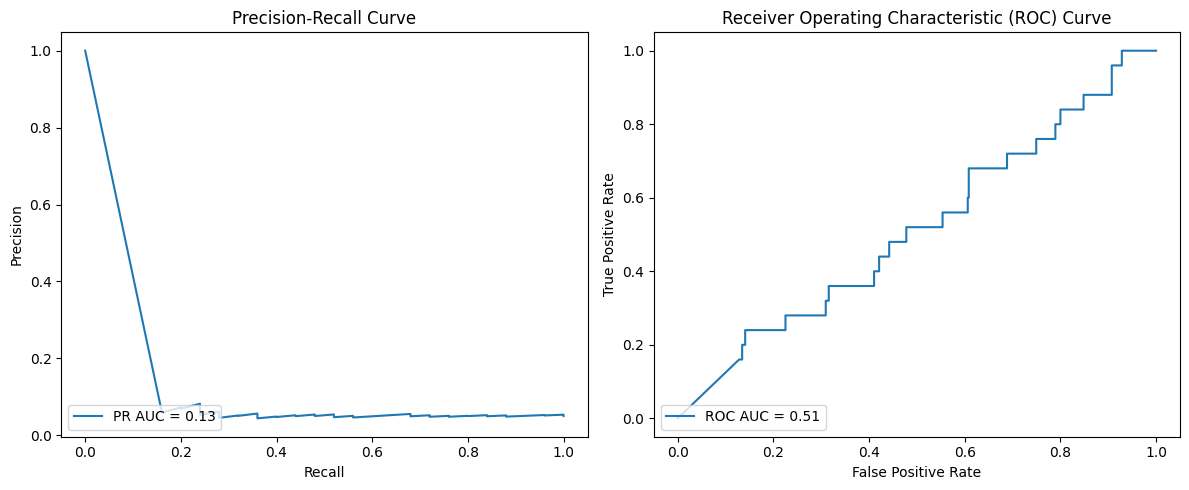

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Step 4: Plot the PR and ROC curves
plt.figure(figsize=(12, 5))

# Precision-recall curve
plt.subplot(1, 2, 1)
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# ROC curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()
